In [1]:
import pandas as pd
import requests
import numpy as np
from datetime import datetime, date, time
import matplotlib.pyplot as plt
import time
from tkinter import *
%matplotlib inline

In [2]:
def take_all_members(limit_of_request, domain):
    token = "5343fbfa5343fbfa5343fbfa75532dfc8d553435343fbfa0d5cf54c0d863d963693d525"
    version = 5.92
    #domain = 'akylikea'
    fields = 'bdate,city,country,last_seen,occupation,relation,sex'
    count = 1000
    offset = 0
    response = requests.get('https://api.vk.com/method/groups.getMembers',
                            params={
                                'offset': offset,
                                'count': count,
                                'access_token': token,
                                'group_id': domain,
                                'v': version,
                                'fields': fields
                            }
                            )
    num_items = response.json()['response']['count']

    if num_items < count:
        count = num_items
        print(1, 'num_items', num_items, 'count', count)

    response = requests.get('https://api.vk.com/method/groups.getMembers',
                            params={
                                'offset': offset,
                                'count': count,
                                'access_token': token,
                                'group_id': domain,
                                'v': version,
                                'fields': fields
                            }
                            )
    data = response.json()['response']['items']
    all_members = data
    num_items -= count
    
    while (offset < limit_of_request and num_items > 0):
        offset += count
        if num_items < count:
            count = num_items
        num_items -= count
        response = requests.get('https://api.vk.com/method/groups.getMembers',
                                params={
                                    'offset': offset,
                                    'count': count,
                                    'access_token': token,
                                    'group_id': domain,
                                    'v': version,
                                    'fields': fields
                                }
                                )
        data = response.json()['response']['items']
        all_members = list(np.append(all_members, data))
    return all_members

In [3]:
def making_data_frame(all_memberss):

    columns = [['first_name'], ['sex'], ['bdate'], ['relation']]
    l = len(all_memberss)

    for col in columns:
        for i in range(0, l):
            try:
                col.append(all_memberss[i][col[0]])
            except KeyError:
                col.append('-')

    columns_dop = [['city', 'title'],
                   ['country', 'title'],
                   ['last_seen', 'time'], ['last_seen', 'platform'],
                   ['occupation', 'type']]

    for col in columns_dop:
        for i in range(0, l):
            try:
                col.append(all_memberss[i][col[0]][col[1]])
            except KeyError:
                col.append('-')

    for col in columns_dop:
        col[0] = col[0]+'_'+col[1]
        del col[1]

    columns.extend(columns_dop)
    data_arr = np.array(columns)
    data_arr = data_arr.transpose()

    df = pd.DataFrame(data_arr[1:], columns=data_arr[0])
    return df

In [4]:
def get_last_time (last_seen_time):
    timestamp = int(time.time())
    seconds_in_day = 60*60*24
    if last_seen_time != '-':
        seconds_from_last_seen = timestamp - int(last_seen_time)
        if seconds_from_last_seen <= seconds_in_day*7:
            last_time = 'active'
        else:
            last_time = 'inactive'
    else:
        last_time = '-'
    return last_time

In [5]:
def accounts_activity (df):
    
    df['activity'] = [get_last_time(item) for item in df['last_seen_time']]
    
    num_active = len(df[df.activity == 'active'])
    num_inactive = len(df[df.activity == 'inactive'])
    num_no_act_inf = len(df[df.activity == '-'])
    num_deleted = len(df[df.first_name == 'DELETED'])
    
    act_el_clear = [num_active, num_inactive, num_no_act_inf, num_deleted]
    all_act = len(df)
    act_el = [i/all_act*100 for i in act_el_clear]
    labels = ["%1.1f%%" % i for i in act_el]
    
    fig, ax = plt.subplots()
    s = [num_active, num_inactive, num_no_act_inf]
    x = np.arange(len(s))
    ax.set_xticks(x)
    ax.set_xticklabels(['Активные аккаунты', 'Малоактивные аккаунты\n (последняя активность\n более 7 дней назад)', 
                        'Нет информации\n об активности аккаунтов'], fontsize = 12)
    ax.bar(x, s, color = 'paleturquoise', width = 0.5)
    ax.bar(2, num_deleted, color = 'orchid', alpha=0.5)
    ax.legend(['Существующие аккаунты', 'Удаленные аккаунты'], fontsize=12, title = 'Тип аккаунта', title_fontsize = 12)
    ax.set_title('Активность аккаунтов сообщества', fontsize=14)
    
    for i in range(3):
        ax.text(i, act_el_clear[i]/2, labels[i], ha='center', va='center', fontsize=12)
    ax.text(2.35, act_el_clear[3], labels[3], ha='center', va='bottom', fontsize=12)
    
    fig.set_figwidth(12)    #  ширина и
    fig.set_figheight(6)    #  высота "Figure"
    plt.yticks(fontsize=12)
    plt.ylabel('Число аккаунтов', fontsize=13)
    plt.show()

In [6]:
def get_age(birthday_str):
    try:
        birthdate = datetime.strptime(birthday_str, '%d.%m.%Y').date()
        today = date.today()
        age = today.year - birthdate.year
        if today.month < birthdate.month:
            age -= 1
        elif today.month == birthdate.month and today.day < birthdate.day:
            age -= 1
    except ValueError:
        age = '-'
    return age

In [7]:
def age_group (age):
    if age == '-':
        group_id = '-'
    else:
        age_val = int(age)
        if age_val<18:
            group_id = '1'
        elif age_val>=18 and age_val<31:
            group_id = '2'
        elif age_val>=31 and age_val<44:
            group_id = '3'
        elif age_val>=44 and age_val<60:
            group_id = '4'
        else:
            group_id = '5'
    
    return(group_id)

In [10]:
def countries(hist_df):
    hist_df1 = hist_df.copy()
    hist_df1 = hist_df1.sort_values('Сумма', ascending=True)
    check_sum = 0
    while True:
        for i in range(len(hist_df1['Сумма'])-1,-1,-1):
            check_sum += hist_df1['Сумма'][i]
            if (check_sum >= hist_df1['Сумма'].sum()*0.95) or (len(hist_df1['Сумма'])-i > 10) :
                break
        break
    hist_df1 = hist_df1.reset_index()
    hist_df1 = hist_df1.transpose()
    for j in range(i-2, -1, -1):
        hist_df1[i-1] = hist_df1[i-1]+hist_df1[j]
        del hist_df1[j]
    hist_df1[i-1]['index'] = 'Остальные'
    hist_df1 = hist_df1.transpose()
    #hist_df = hist_df.sort_values('Сумма')
    del hist_df1['Сумма']
    indexes = [x for x in hist_df1['index']]
    hist_df1.index = indexes
    del hist_df1['index']
    return hist_df1

In [11]:
def hist_df_construct(feature_X, feature_Y, df):
    h_vals_r = []
    if (feature_Y == 'country_title') or (feature_Y == 'city_title'):
        for key_Y in set(df[feature_Y]):
            h_vals_el = []
            for key_X, val_X in dict_sample[feature_X].items():
                h_sum = len(df[(df.first_name != 'DELETED')&(df[feature_X] == key_X)&(df[feature_Y] == key_Y)])
                h_vals_el.append(h_sum)
            h_vals_el.append(sum(h_vals_el))
            h_vals_r.append(h_vals_el)

    else:
        for key_Y, val_Y in dict_sample[feature_Y].items():
            h_vals_el = []
            for key_X, val_X in dict_sample[feature_X].items():
                h_sum = len(df[(df.first_name != 'DELETED')&(df[feature_X] == key_X)&(df[feature_Y] == key_Y)])
                h_vals_el.append(h_sum)
            h_vals_el.append(sum(h_vals_el))
            h_vals_r.append(h_vals_el)

    if feature_Y == 'country_title' or (feature_Y == 'city_title'):
        indexes = [x for x in set(df[feature_Y])]
        ind_of_desh = indexes.index('-')
        indexes[ind_of_desh] = 'информация недоступна'
    else:
        indexes = [val_Y for key_Y, val_Y in dict_sample[feature_Y].items()]

    columns = [x for x in dict_sample[feature_X].values()]
    columns.append('Сумма')

    hist_df = pd.DataFrame(np.array(h_vals_r), columns = columns)
    hist_df.index = indexes

    if feature_Y == 'country_title' or (feature_Y == 'city_title'):
        hist_df = countries(hist_df)
    elif feature_Y == 'age_groups':
        del hist_df['Сумма']
    else:
        hist_df = hist_df.sort_values('Сумма')
        del hist_df['Сумма']

    return hist_df

In [12]:
def histtogram_constructor(feature_Y, feature_X, hist_df):
    h_height = 10
    ax = hist_df.plot.barh(stacked=True, cmap = 'Set3', figsize = (12,h_height), fontsize=11)
    ax.set_title(titles_for_hists[feature_Y+'_'+feature_X]['title'], fontsize=14)
    ax.legend(fontsize=11,title = titles_for_hists[feature_Y+'_'+feature_X]['title_legend'], title_fontsize = 12,
             loc = 'center right')
    plt.ylabel(titles_for_hists[feature_Y+'_'+feature_X]['title_Y'], fontsize=14)
    plt.xlabel('Число аккаунтов', fontsize=14)
    #plt.show()
    dst_hist = mpld3.fig_to_html(fig)
    plt.savefig('dst_hist.png')
    plt.close()

In [13]:
def modas (df):
    var_list_all = ['sex', 'age_groups', 'last_seen_platform', 'occupation_type', 'relation', ]
    mode_list = []
    otvet = []
    for item in var_list_all:
        p = df[(df[item]!='-')&(df[item]!='0')][item].mode()
        mode_list.append([item, p[0]])
    for i in range(len(var_list_all)):
        otvet.append(dict_sample[var_list_all[i]][mode_list[i][1]])
    otvet.append(df[(df['country_title']!='-')]['country_title'].mode()[0])
    otvet.append(df[(df['city_title']!='-')]['city_title'].mode()[0])
    return otvet

In [14]:
def final_operations(limit_of_request, var_list, domain):
    
    all_memberss = take_all_members(int(limit_of_request), domain)
    df = making_data_frame(all_memberss)
    df['age'] = [get_age(str(item)) for item in df['bdate']]            
    df['age_groups'] = [age_group(item) for item in df['age']]
    
    otvet = modas (df)
    print('Целевой аудиторией являются аккаунты, у которых: '
          'пол - %s, '
          'возраст - %s' 
          'основная платформа доступа к социальной сети Вконтакте - %s, '
          'тип занятости - %s, '
          'семейное положение - %s и проживающие в стране  - %s, городе - %s.'  
          % (otvet[0], otvet[1], otvet[2], otvet[3], otvet[4], otvet[5], otvet[6]))
    
    accounts_activity (df)
    for i in range(len(var_list)-1):
        for j in range(i+1, len(var_list)):
            if len(set(df[var_list[i]])) >= len(set(df[var_list[j]])):
                feature_Y = var_list[i]
                feature_X = var_list[j]
            else:
                feature_Y = var_list[j] 
                feature_X = var_list[i]
            hist_df = hist_df_construct(feature_X, feature_Y, df)
            histtogram_constructor(feature_Y, feature_X, hist_df)

In [8]:
dict_sample = {
    'last_seen_platform': {
        '1': 'мобильная версия',
        '2': 'приложение для iPhone',
        '3': 'приложение для iPad',
        '4': 'приложение для Android',
        '5': 'приложение для Windows Phone',
        '6': 'приложение для Windows 10',
        '7': 'полная версия сайта',
        '-': 'информация недоступна'},
    'age_groups': {
        '1': 'до 18',
        '2': 'от 18 до 31',
        '3': 'от 31 до 44',
        '4': 'от 44 до 60',
        '5': 'старше 60',
        '-': 'информация недоступна'},
    'occupation_type': {
        'school': 'школьник', 
        'university': 'студент', 
        'work': 'работает',
        '-': 'информация недоступна'},
    'relation': {
        '1': 'не женат/не замужем',
        '2': 'есть друг/есть подруга',
        '3': 'помолвлен/помолвлена',
        '4': 'женат/замужем',
        '5': 'всё сложно',
        '6': 'в активном поиске',
        '7': 'влюблён/влюблена',
        '8': 'в гражданском браке',
        '0': 'не указано',
        '-': 'информация недоступна'},
    'sex': {
        '1': 'женский',
        '2': 'мужской',
        '0': 'не указано'},
}

In [9]:
titles_for_hists = {
    'last_seen_platform_age_groups': {
        'title': 'Гистограмма распределения выбора платформы для доступа к социальной сети Вконтакте\n в зависимости от возрастной группы',
        'title_Y': 'Платформа для доступа',
        'title_legend': 'Возрастная группа'},
    
    'last_seen_platform_occupation_type':{
        'title': 'Гистограмма распределения выбора платформы для доступа к социальной сети Вконтакте\n в зависимости от рода деятельности',
        'title_Y':'Платформа для доступа',
        'title_legend': 'Род деятельности'},
    
    'relation_last_seen_platform':{
        'title': 'Гистограмма распределения семейного положения\n в зависимости от выбора платформы для доступа к социальной сети Вконтакте',
        'title_Y':'Семейное положение',
        'title_legend': 'Платформа для доступа'},
    
    'last_seen_platform_sex': {
        'title': 'Гистограмма распределения выбора платформы для доступа к социальной сети Вконтакте\n в зависимости от пола',
        'title_Y':'Платформа для доступа',
        'title_legend': 'Пол'},
    
    'country_title_last_seen_platform': {
        'title': 'Гистограмма распределения географического положения\n в зависимости от выбора платформы для доступа к социальной сети Вконтакте',
        'title_Y':'Страна',
        'title_legend': 'Платформа для доступа'},
    
    'age_groups_occupation_type': {
        'title': 'Гистограмма распределения возрастных групп\n в зависимости от рода деятельности',
        'title_Y':'Возрастная группа',
        'title_legend': 'Род деятельности'},
    
    'relation_age_groups': {
        'title': 'Гистограмма распределения семейного положения\n в зависимости от возрастной группы',
        'title_Y':'Семейное положение',
        'title_legend': 'Возрастная группа'},
    
    'age_groups_sex': {
        'title': 'Гистограмма распределения возрастных групп\n в зависимости от пола',
        'title_Y':'Возрастная группа',
        'title_legend': 'Пол'},
    
    'country_title_age_groups': {
        'title': 'Гистограмма распределения географического положения\n в зависимости от возрастной группы',
        'title_Y':'Страна',
        'title_legend': 'Возрастная группа'},
    
    'relation_occupation_type': {
        'title': 'Гистограмма распределения семейного положения\n в зависимости от рода деятельности',
        'title_Y':'Семейное положение',
        'title_legend': 'Род деятельности'},
    
    'occupation_type_sex': {
        'title': 'Гистограмма распределения рода деятельности\n в зависимости от пола',
        'title_Y':'Род деятельности',
        'title_legend': 'Пол'},
    
    'country_title_occupation_type': {
        'title': 'Гистограмма распределения географического положения\n в зависимости от рода деятельности',
        'title_Y':'Страна',
        'title_legend': 'Род деятельности'},
    
    'relation_sex': {
        'title': 'Гистограмма распределения семейного положения\n в зависимости от пола',
        'title_Y':'Семейное положение',
        'title_legend': 'Пол'},
    
    'country_title_relation': {
        'title': 'Гистограмма распределения географического положения\n в зависимости от семейного положения',
        'title_Y':'Страна',
        'title_legend': 'Семейное положение'},
    
    'country_title_sex': {
        'title': 'Гистограмма распределения географического положения\n в зависимости от пола',
        'title_Y':'Страна',
        'title_legend': 'Пол'},
    
    'city_title_relation': {
        'title': 'Гистограмма распределения регионального расположения\n в зависимости от семейного положения',
        'title_Y':'Город',
        'title_legend': 'Семейное положение'},
    
    'city_title_sex': {
        'title': 'Гистограмма распределения регионального расположения\n в зависимости от пола',
        'title_Y':'Город',
        'title_legend': 'Пол'},
    
    'city_title_last_seen_platform': {
        'title': 'Гистограмма распределения регионального расположения\n в зависимости от выбора платформы для доступа к социальной сети Вконтакте',
        'title_Y':'Город',
        'title_legend': 'Платформа для доступа'},
    
    'city_title_age_groups': {
        'title': 'Гистограмма распределения регионального расположения\n в зависимости от возрастной группы',
        'title_Y':'Город',
        'title_legend': 'Возрастная группа'},
    
    'city_title_occupation_type': {
        'title': 'Гистограмма распределения регионального расположения\n в зависимости от рода деятельности',
        'title_Y':'Город',
        'title_legend': 'Род деятельности'},
    'city_title_country_title': {
        'title': 'Гистограмма распределения географического расположения\n в зависимости от географического положения',
        'title_Y':'Город',
        'title_legend': 'Страна'}
}

In [15]:
def get_some_input():
    var_list = ['last_seen_platform', 'age_groups', 'occupation_type', 'relation', 'sex', 'country_title', 'city_title']
    var_list_check = ['Платформа для доступа к\n социальной сети Вконтакте', 'Возраст', 'Род занятости', 
                      'Семейное положение', 'Пол', 'Страна', 'Город']
    check_w = [0]*len(var_list)
    check_a = [0]*len(var_list)

    root = Tk()
    frame = Frame(root)
    root.title("Анализ аккаунтов социальных сетей")
    root.geometry("300x500")
    Label(root, text="Выберите характеристики для анализа:").grid(row=0, sticky=W)

    for i in range(len(var_list_check)):
        check_w[i] = IntVar()
        checkbutton = Checkbutton(text=var_list_check[i], variable=check_w[i], onvalue=1, offvalue=0, padx=15, pady=10)
        checkbutton.grid(row=i+1, column=0, sticky=W)

    #button = Button (frame, text="Good-bye.", command=root.destroy)
    #button.grid(row=i+2, sticky=W)
    root.mainloop()
    
    for i in range(len(check_w)):
        if check_w[i].get() != 1:
            var_list[i] = 0
    var_list = [i for i in var_list if i != 0]
    
    limit_of_request = input('Введите ограничение на число аккаунтов для обработки: ')
    domain = input('Введите домен сообщества: ')
    
    return (limit_of_request, var_list, domain)

In [16]:
    for i in range(len(check_w)):
        if check_w[i].get() != 1:
            var_list[i] = 0
    var_list = [i for i in var_list if i != 0]
    var_list

['last_seen_platform', 'age_groups', 'occupation_type', 'relation', 'sex']

In [17]:
limit_of_request = input('Введите ограничение на число аккаунтов для обработки: ')

Введите ограничение на число аккаунтов для обработки: 100000


In [18]:
domain = input('Введите домен сообщества: ')

Введите домен сообщества: bestad


Целевой аудиторией являются аккаунты, у которых: пол - женский, возраст - от 31 до 44основная платформа доступа к социальной сети Вконтакте - приложение для iPhone, тип занятости - студент, семейное положение - женат/замужем и проживающие в стране  - Russia, городе - Saint Petersburg.


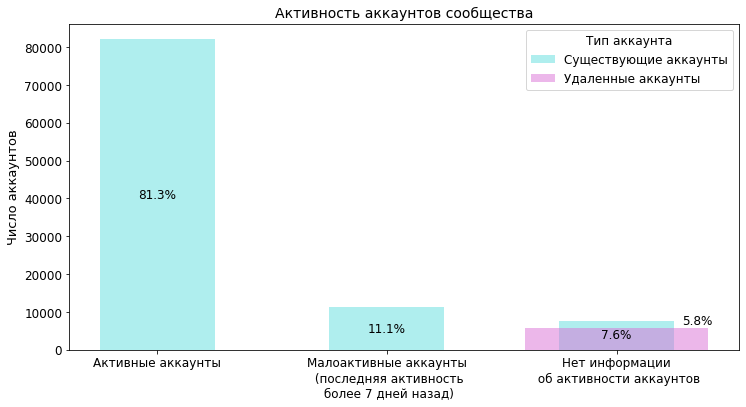

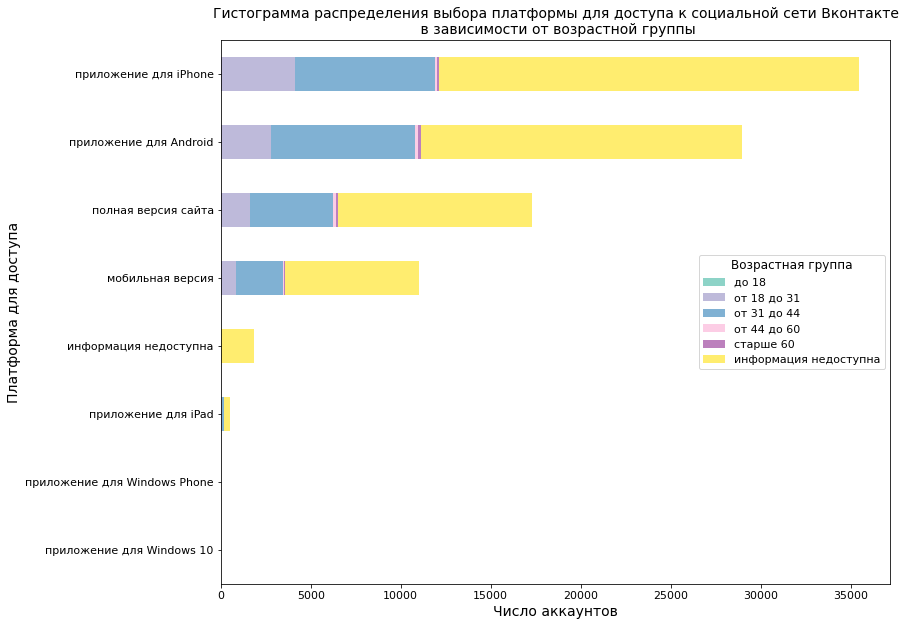

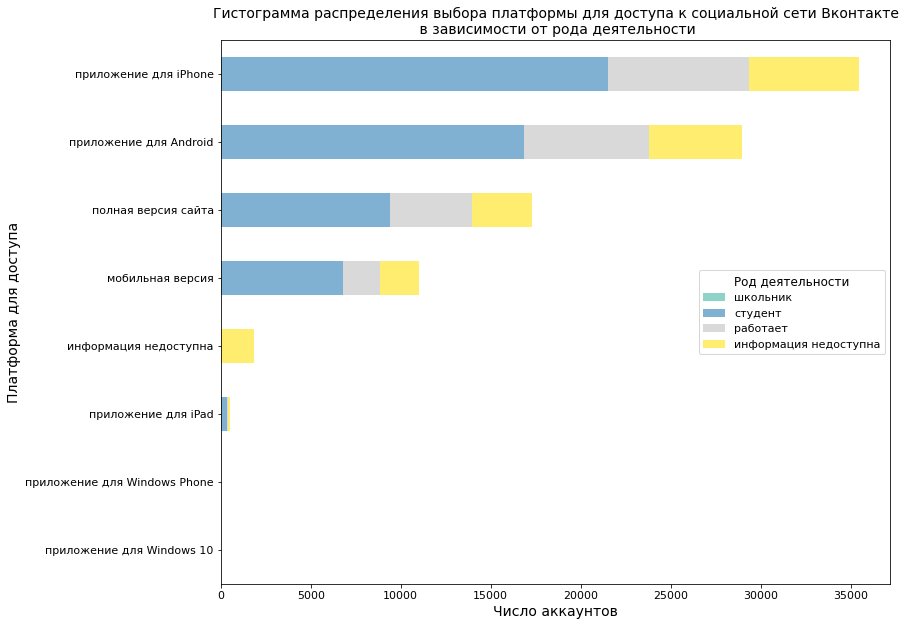

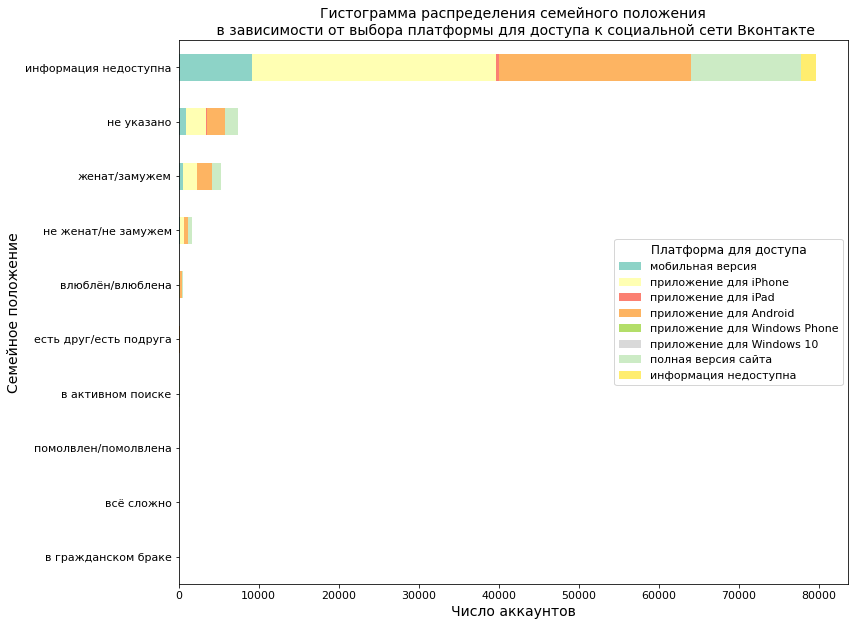

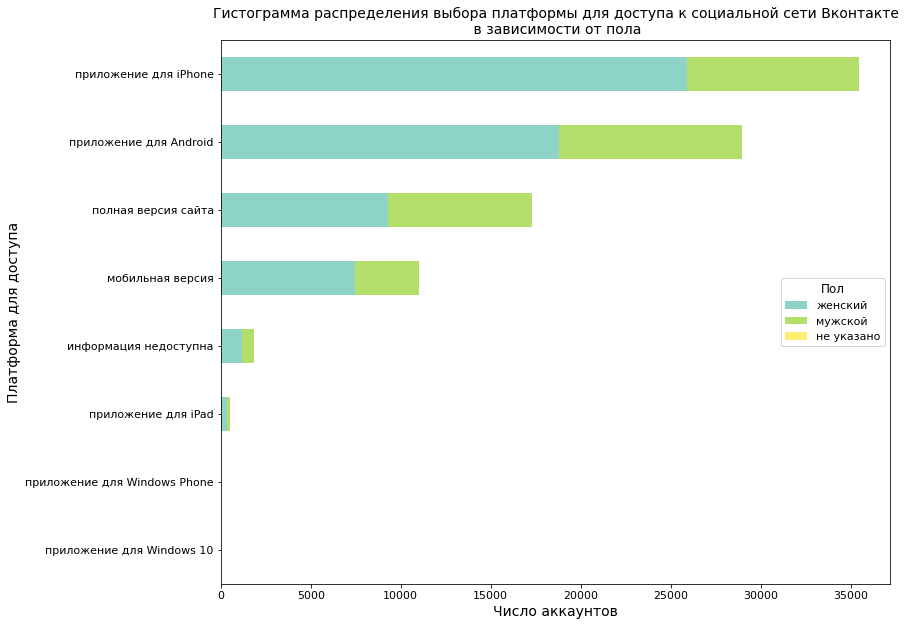

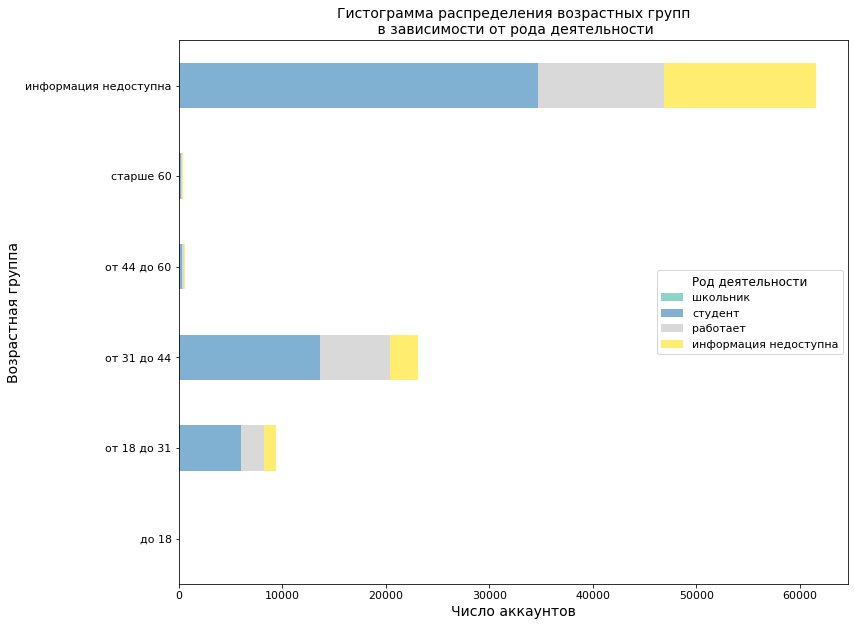

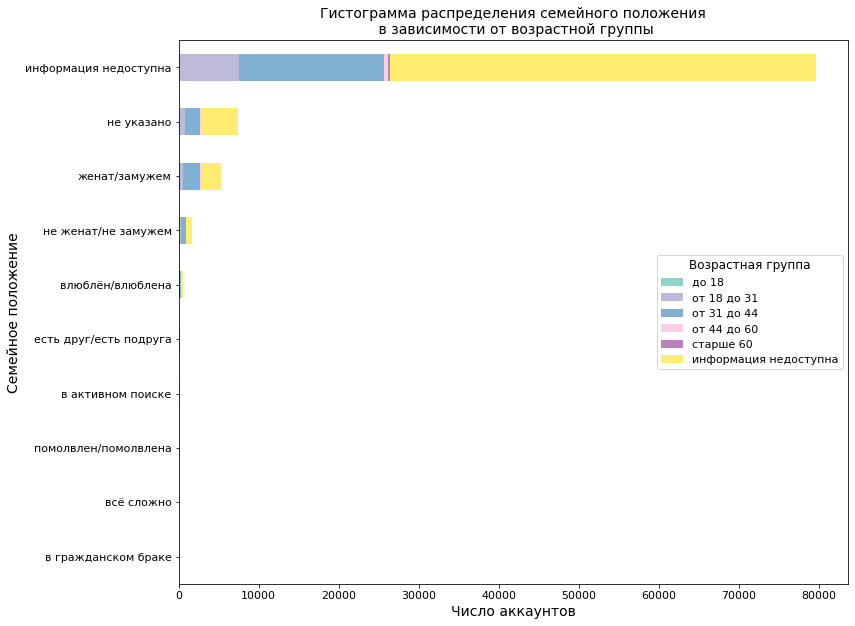

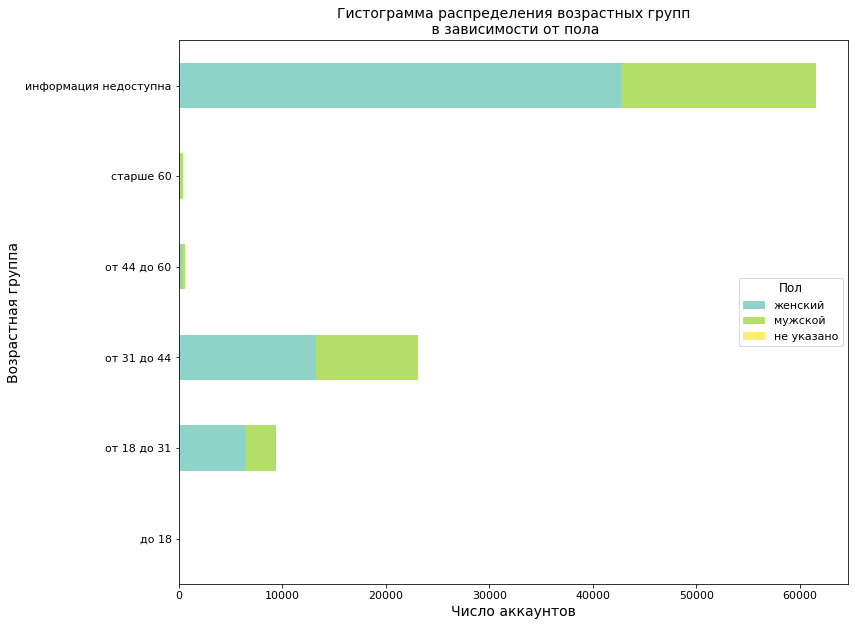

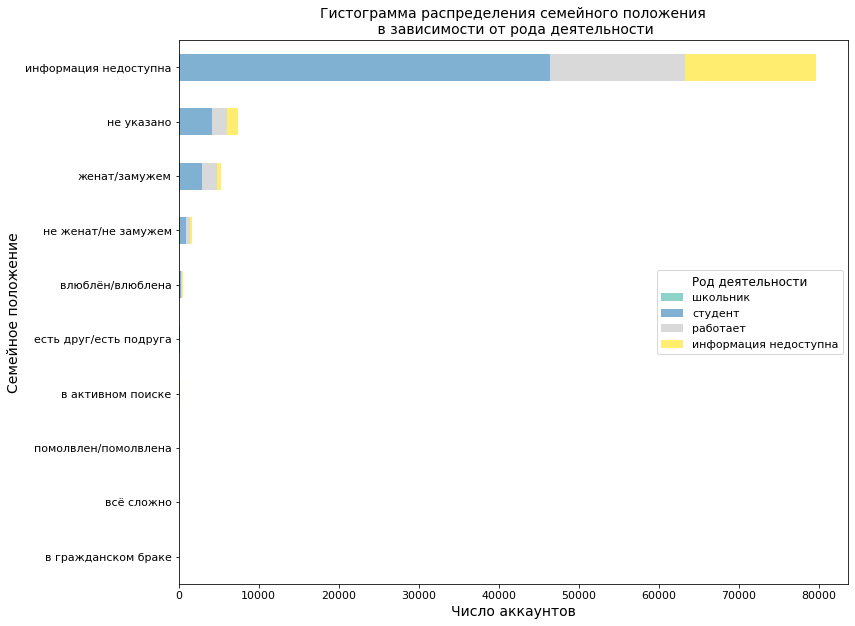

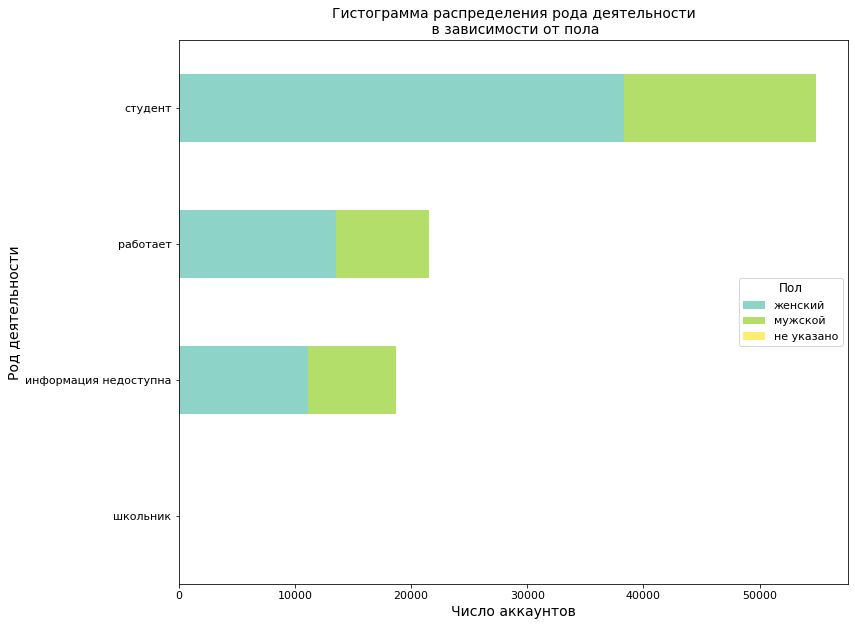

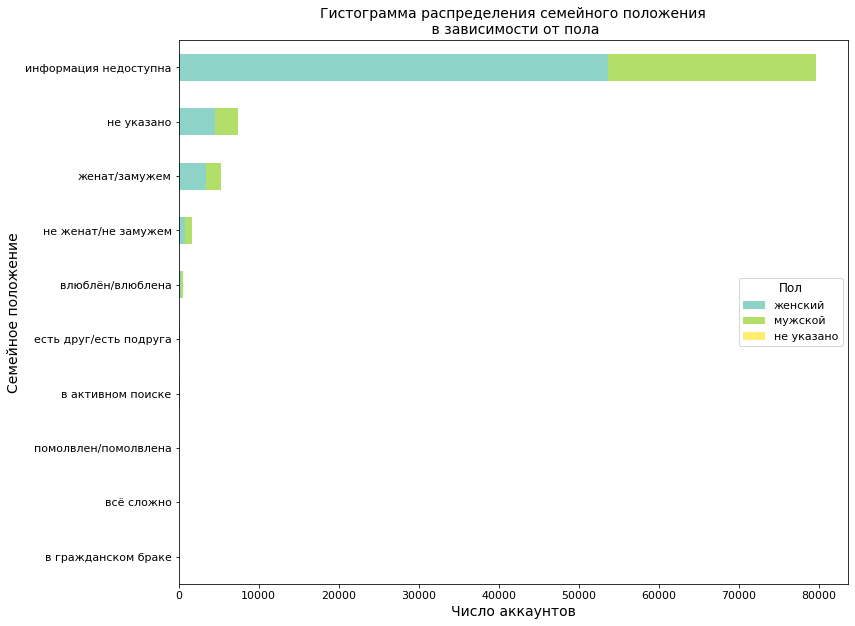

In [19]:
final_operations(get_some_input())